In [18]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns  
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

## Data Loading

In [3]:
ds_hb = xr.open_dataset("../data/20241227/merged-20241227.nc")
ds_hb

<xarray.Dataset> Size: 55MB
Dimensions:  (id: 786, time: 8800)
Coordinates:
  * id       (id) int64 6kB 1 2 3 4 5 6 7 8 9 10 ... 57 58 59 60 61 62 63 64 65
    device   (id) int64 6kB ...
    name     (id) <U28 88kB ...
Dimensions without coordinates: time
Data variables:
    signal   (id, time) float64 55MB ...
    hb       (id) float64 6kB ...

In [4]:
np.unique(ds_hb["device"].to_numpy())

array([ 2,  7,  9, 11, 12, 13, 15])

In [25]:
# ds_hb_sel = ds_hb
ds_hb_sel = ds_hb.sel(id=ds_hb["device"] == 2) 

X = ds_hb_sel["signal"].to_numpy()
y = ds_hb_sel["hb"].to_numpy()

## Regressor

### Cross-Validation

In [26]:
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [27]:
scores = cross_validate(SVR(), X, y, scoring=["r2", "neg_mean_absolute_error", "neg_mean_squared_error", "neg_root_mean_squared_error"])
scores_df = pd.DataFrame(scores)
scores_df

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.008825,0.004413,-0.088446,-1.844169,-4.609796,-2.147043
1,0.006969,0.004518,-0.008560,-1.677506,-3.570863,-1.889673
2,0.006879,0.004165,-0.066473,-1.331926,-2.538798,-1.593360
3,0.005818,0.003944,-0.102066,-1.295131,-2.274771,-1.508235
4,0.005905,0.004718,-0.258230,-1.082521,-2.272066,-1.507337


In [28]:
scores_df.mean()

fit_time                            0.006879
score_time                          0.004352
test_r2                            -0.104755
test_neg_mean_absolute_error       -1.446251
test_neg_mean_squared_error        -3.053259
test_neg_root_mean_squared_error   -1.729130
dtype: float64

### Hold-out

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((42, 8800), (18, 8800), (42,), (18,))

In [30]:
reg = SVR()
reg.fit(X_train, y_train)

SVR()

### Evaluate Performance

In [31]:
y_pred = reg.predict(X_test)
df_pred = pd.DataFrame({
    "hb_gold": y_test,
    "hb_pred" : y_pred,
    "hb_resid": y_test - y_pred,
}).sort_values("hb_gold")

In [32]:
r, _ = pearsonr(df_pred["hb_gold"], df_pred["hb_pred"])

print(f"R = {r:.4f}")
print(f"R2 = {r2_score(df_pred['hb_gold'], df_pred['hb_pred']):.4f}")
print(f"MAE = {mean_absolute_error(df_pred['hb_gold'], df_pred['hb_pred']):.4f}")
print(f"MSE = {mean_squared_error(df_pred['hb_gold'], df_pred['hb_pred']):.4f}")
print(f"RMSE = {root_mean_squared_error(df_pred['hb_gold'], df_pred['hb_pred']):.4f}")

R = 0.1435
R2 = -0.0004
MAE = 1.0963
MSE = 2.0971
RMSE = 1.4481


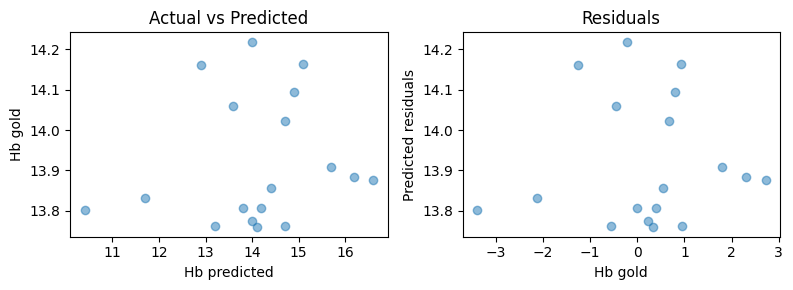

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].scatter(df_pred["hb_gold"], df_pred["hb_pred"], alpha=0.5)
ax[0].set_title("Actual vs Predicted")
ax[0].set_xlabel("Hb predicted")
ax[0].set_ylabel("Hb gold")

ax[1].set_title("Residuals")
ax[1].scatter(df_pred["hb_resid"], df_pred["hb_pred"], alpha=0.5)
ax[1].set_xlabel("Hb gold")
ax[1].set_ylabel("Predicted residuals")

fig.tight_layout()
plt.show()

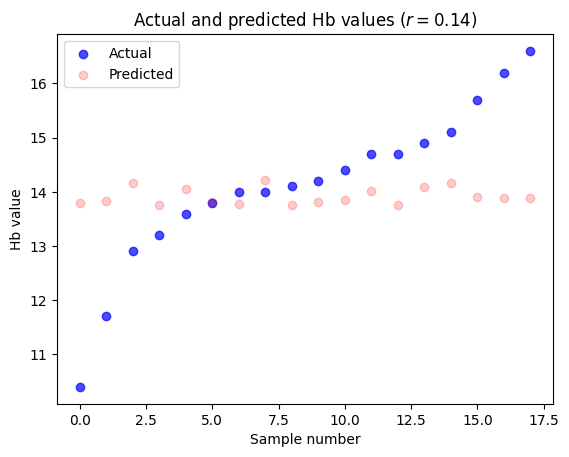

In [34]:
fig, ax = plt.subplots()  
ax.scatter(range(df_pred.shape[0]), df_pred["hb_gold"], c='b', alpha=0.7, label="Actual")
ax.scatter(range(df_pred.shape[0]), df_pred["hb_pred"], c='r', alpha=0.2, label="Predicted")
ax.legend()

ax.set_title(f"Actual and predicted Hb values ($r={r:.2f}$)")
ax.set_xlabel("Sample number")
ax.set_ylabel("Hb value")

plt.show()